# 0) Import Library

In [1]:
# Library
import json
import csv

import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

import numpy as np
import os
from datetime import datetime
import keras

# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


# 1) Function

In [0]:
# Tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [0]:
# Define Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

# 2) Prepare Dataset


## 2.1) Download Data

In [4]:
# Download data
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True) 

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteF6TZ0B/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteF6TZ0B/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteF6TZ0B/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [0]:
train_data, test_data = imdb['train'], imdb['test']  # 25K for train, 25K for test

## 2.2) Data Analysis


## 2.3) Data Visualization

## 2.4) Data Preprocessing


In [0]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [7]:
print('Dimension training', len(training_labels_final))
print('Dimension testing', len(testing_labels_final))
print(training_sentences[0])
print(training_labels[0])

Dimension training 25000
Dimension testing 25000
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0


In [0]:
# Tokenize & Padding

vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences) #25K list of sequence
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type) # 25K padding list

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


# 3) Define Model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 174,657
Trainable params: 174,657
Non-trainable params: 0
_________________________________________________________________


# 4) Training

In [0]:
# Compile Model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
# Fitting and evaluate
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), callbacks=[tensorboard_callback])

Epoch 1/10
782/782 [==============================] - 49s 62ms/step - loss: 0.4642 - accuracy: 0.7692 - val_loss: 0.3699 - val_accuracy: 0.8392
Epoch 2/10
782/782 [==============================] - 47s 60ms/step - loss: 0.2906 - accuracy: 0.8828 - val_loss: 0.3528 - val_accuracy: 0.8455
Epoch 3/10
782/782 [==============================] - 47s 60ms/step - loss: 0.2274 - accuracy: 0.9136 - val_loss: 0.3835 - val_accuracy: 0.8270
Epoch 4/10
782/782 [==============================] - 47s 60ms/step - loss: 0.1789 - accuracy: 0.9356 - val_loss: 0.4323 - val_accuracy: 0.8300
Epoch 5/10
782/782 [==============================] - 47s 60ms/step - loss: 0.1307 - accuracy: 0.9550 - val_loss: 0.5009 - val_accuracy: 0.8174
Epoch 6/10
782/782 [==============================] - 47s 60ms/step - loss: 0.0998 - accuracy: 0.9656 - val_loss: 0.5798 - val_accuracy: 0.8189
Epoch 7/10
782/782 [==============================] - 47s 60ms/step - loss: 0.0703 - accuracy: 0.9772 - val_loss: 0.6522 - val_accuracy:

## TensorBoard

In [0]:
%tensorboard --logdir logs

# 5) Value on Testing/Validation

In [15]:
model.evaluate(testing_padded, testing_labels_final, steps=100)

100/100 [==============================] - 2s 18ms/step - loss: 0.9271 - accuracy: 0.8149


[0.9270934462547302, 0.8149200081825256]

# 6) Plot Result

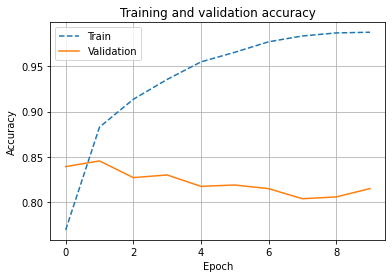

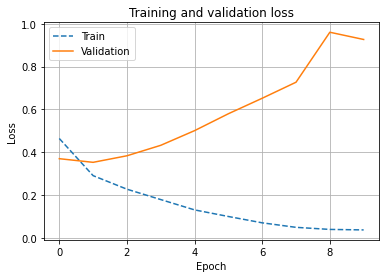

In [14]:
# Retrieve Values of accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

# Plot accuracy and loss
plt.figure(edgecolor='w', facecolor='white')
plt.grid()
plt.plot(epochs,acc, linestyle = 'dashed', label = 'Train' )
plt.plot(epochs, val_acc, label = 'Validation')
plt.title ('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation
plt.figure(edgecolor='w', facecolor='white')
plt.grid()
plt.plot( epochs,loss, linestyle = 'dashed', label = 'Train')
plt.plot( epochs, val_loss, label = 'Validation')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()